In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import random

from xgboost import plot_importance
from xgboost import XGBRegressor
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [2]:
df = pd.read_csv('../data/processed_data/merged_characteristics.csv')

########create mkt share data for logit
logit_keys = ['market_ids', 'product_ids', 'firm_ids', 'shares', 'prices', 'demand_instruments0']
nonlinear_cols = ['EHBPercentTotalPremium']
linear_cols = [ 'act_value','MetalLevel_Platinum', 'MetalLevel_Silver','Plan Counts']
mkt_cols = [ 'DP05_0015PE' ,'DP05_0069PE','S1701_C01_017E','StateCodeFL'] 
firm_cols =  linear_cols+ nonlinear_cols   
logit_x_cols = firm_cols + mkt_cols + ['DP03_0095E']


############keys for boosted trees...
keys = ['HIOS ID', 'IssuerId', 'County', 'State', 'FIPS County Code', 'Policy County FIPS Code','County Name']
missing_cols = ['DP05_0028PE', 'Number of Consumers with CSR AV of 87%', 
                'Average Monthly Advanced CSR Payment for Consumers with 87%', 
                'DP05_0018PE', 'Number of Consumers with CSR (AV of 73%/87%/94%)', 'Total Number of Consumers',
                'Number of Consumers with CSR AV of 73%', 'Number of Consumers with CSR AV of 94%','FIPS County Code',
                'Average Monthly Advanced CSR Payment for Consumers with 73%', 
                'Average Monthly Advanced CSR Payment for Consumers with 94%', 
                'DP05_0032PE', 'DP05_0004PE', 'County Name']

#setup y
y_cols = ['Ever Enrolled Count']
keys = ['HIOS ID', 'IssuerId', 'County', 'State', 'FIPS County Code', 'Policy County FIPS Code','County Name']

In [3]:
def create_logit_data(df):
    df = df.copy()
    
    #create market data...
    df['shares'] = df['Ever Enrolled Count']/df['DP03_0095E']
    #add logit columns
    df['product_ids'] = df['IssuerId'].astype(str) +  df['County'].astype(str) 

    #demand_instrument0
    MktIds = np.array(pd.get_dummies(df['IssuerId']))
    MktIds2 = (MktIds.T).dot(MktIds)
    dummies_proj = MktIds.dot( np.linalg.inv( MktIds2 ) ).dot( MktIds.T )
    df['demand_instruments0'] = dummies_proj.dot(df['PREMI27']) #average price across markets

   
    #fix problematic columns
    df = df.rename(columns={'Average Monthly Advanced CSR Payment for Consumers with 94%':'csr_pay_94',
                      'Average Monthly Advanced CSR Payment for Consumers with 87%':'csr_pay_87',
                           'Total Number of Consumers':'csr_tot',
                            'Number of Consumers with CSR AV of 94%':'csr_tot_94'
                           ,'PREMI27':'prices', 'County':'market_ids', 'IssuerId':'firm_ids'})
    
    #standardize the cols
    for col in firm_cols:
        df[col] = df[col]/df[col].std()
    df = df[df['shares']!=0]
    
    
    ######### preprocess lasso data
    lasso_x_cols = ['prices']

    for col in df.columns:
        if (col not in y_cols and col not in keys and col not in missing_cols 
            and not 'StateCode' in col and not 'IssuerId' in col and 'csr_' not in col
            and col not in logit_keys and col not in logit_x_cols):
                df[col] = df[col]/df[col].std()
                lasso_x_cols.append(col) 
    
    df = df.fillna(0)
    
    all_cols = list(set(logit_keys + logit_x_cols + y_cols+lasso_x_cols+logit_x_cols))
    clean_df = df[all_cols]
    return sm.add_constant(clean_df),lasso_x_cols


clean_df,lasso_x_cols = create_logit_data(df)

print(clean_df['prices'].mean()),#(1-clean_df['shares'].mean()))
print(clean_df['Ever Enrolled Count'].sum())
print( (clean_df['shares']*clean_df['DP03_0095E']).sum() )

142.14997349144596
9870266.0
9870266.0


/home/erichschulman/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [4]:
num_trials = 5
training_test = []

#initilize folds
np.random.seed()
kf = KFold(n_splits=num_trials,shuffle=True)
folds_indexes = kf.split(clean_df)

for fold_index in folds_indexes:
    np.random.seed()
    X_train = clean_df.iloc[fold_index[0]]
    X_test = clean_df.iloc[fold_index[1]]
    training_test.append( (X_train, X_test) )

In [5]:
def get_predictions(model,X_test):
    y_pred = model.predict(X_test)
    y_pred[y_pred < 0] = 0
    return np.array(y_pred).reshape(X_test.shape[0],1)


def plot_prediction(split,y_pred,y_test):
    #setup the data
    
    plt.hist(y_pred[y_test < split],label='predictions',alpha=.5,density=True)
    plt.hist(y_test[y_test < split],label='true',alpha=.5,density=True)
    plt.legend()
    plt.show()

    plt.hist(y_pred[y_test > split],label='predictions',alpha=.5,density=True)
    plt.hist(y_test[y_test > split],label='true',alpha=.5,density=True)
    plt.legend()
    plt.show()
    
    
def plot_importance(X_test,model):
    #use similar code for producing rankings of features according to LASSO
    cols = np.array(X_test.columns)
    importance_raw = model.get_booster().get_score(importance_type='weight')
    importance = []

    for key in importance_raw.keys():
        importance.append([key,importance_raw[key]])

    importance  = pd.DataFrame( importance, columns=['features','score'])
    importance = importance.sort_values('score',ascending=False)

    plt.barh(importance.head(20)['features'].iloc[::-1], importance.head(20)['score'].iloc[::-1])
    plt.show()

    
def report_error(y_test,y_pred):
    y_test = y_test.copy()
    y_test['error'] = np.abs(y_test - y_pred)**2
    y_test['pred'] = y_pred
    result = y_test.merge(df, how='inner',left_index=True, right_index=True,suffixes=('','_x'))
    result  =  result.rename(columns={'Total Number of Consumers':'csr_tot',
                        'Number of Consumers with CSR AV of 94%':'csr_tot_94',
                                     'EHBPercentTotalPremium':'prices'})
    result['shares'] = result['Ever Enrolled Count']/result['DP03_0095E']
    result = result.sort_values('error',ascending=False).head(50)
    #plt.title('20 worst predictions')
    #plt.hist(result['Ever Enrolled Count'],label='true',alpha=.5,density=True)
    #plt.hist(result['pred'],label='pred',alpha=.5,density=True)
    #plt.legend()
    #plt.show()
    
    result_groupby = result.groupby('State')[['pred','Ever Enrolled Count','prices','csr_tot']].mean()
    #MetalLevel_Silver
    result_groupby = result.groupby('State')[['pred','Ever Enrolled Count']].mean()
    result_groupby[['pred_var','enroll_var']] = result.groupby('State')[['pred','Ever Enrolled Count']].std()
    result_groupby = result_groupby.sort_values('pred',ascending=False)
    return result_groupby

------------------
mse normalized trial  0 : r2 -1.2176665043018926
training 1279.7480118509277 predicted share 1246.280029296875 actual 1036.93391521197
------------------
------------------
mse normalized trial  1 : r2 0.09898836267918498
training 1245.4866677062216 predicted share 1326.741943359375 actual 1173.9152119700748
------------------
------------------
mse normalized trial  2 : r2 0.27245996960907437
training 1251.1691612098534 predicted share 1105.70263671875 actual 1151.1334996880848
------------------
------------------
mse normalized trial  3 : r2 0.17973948133015094
training 1150.8766760212036 predicted share 1389.034912109375 actual 1552.4285714285713
------------------
------------------
mse normalized trial  4 : r2 0.38292325060978305
training 1228.5643903960088 predicted share 1059.44287109375 actual 1241.580786026201
------------------


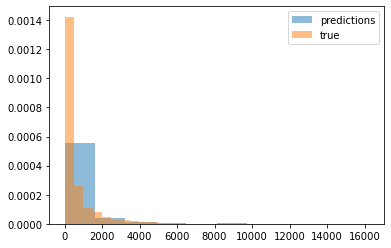

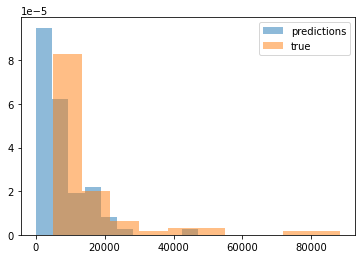

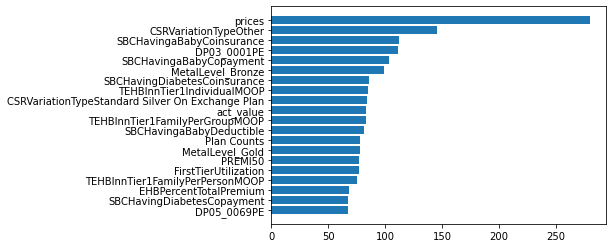

mse 22159275.473123256 r2 0.1064556109348258
mse med 18116851.286845684 r2 med -1.2176665043018926


In [6]:
params = [(5,.1,.5,.3)]
#(2,.2,.5,.9)
#(2,.5,.9,.9),(5,.5, 0.5, .9),

for param in params:
    mses = []
    r2s = []
    for i in range(num_trials):
        X_train, X_test = training_test[i]
        x_cols = lasso_x_cols+logit_x_cols 
        y_cols = ['Ever Enrolled Count']
        
        #reorg data for tree
        y_train = X_train[y_cols]
        y_test = X_test[y_cols]
        X_train = X_train[x_cols]
        X_test = X_test[x_cols]
        
        # not super deep, but uses most of the data at one
        model = XGBRegressor(n_estimators=X_train.shape[1], max_depth=param[0],
                             eta=param[1], subsample=param[2], colsample_bytree=param[3])
        model.fit(X_train, y_train)

        y_pred = get_predictions(model,X_test)
        mse = float( ((y_test - y_pred)**2).mean() )
        r2 = float(  1- mse/y_test.var() )
        print('------------------')
        print('mse normalized trial ', i,': r2', r2)#, mse, float(true_shares.var()) )
        print('training', float(y_train.mean()) ,
          'predicted share', float(y_pred.mean()) ,'actual', float(y_test.mean()))
        print('------------------')
            
        mses.append(mse)
        r2s.append(r2)

        #plot the difference between true and predicted
        if i == num_trials -1:
            split = 5000
            plot_prediction(split,y_pred,y_test)
            plot_importance(X_test,model)
            
    #report fit statistics
    mses,r2s = np.array(mses),np.array(r2s)
    print( 'mse', np.array(mses).mean() ,'r2', 1 - float(np.array(mses).mean()/clean_df['Ever Enrolled Count'].var()) )
    print( 'mse med', np.median(mses) ,'r2 med',r2s.reshape(num_trials,1)[mses == np.median(mses)][0,0] )

------------------
mse normalized trial  0 : r2 0.29588101382663035
training 1279.7480118509277 predicted share 1178.918399124006 actual 1036.93391521197
------------------
------------------
mse normalized trial  1 : r2 0.2341501000552706
training 1245.4866677062216 predicted share 1198.4833823989077 actual 1173.9152119700748
------------------
------------------
mse normalized trial  2 : r2 0.34837455182151145
training 1251.1691612098534 predicted share 1116.391352334109 actual 1151.1334996880848
------------------
------------------
mse normalized trial  3 : r2 0.18825344816687206
training 1150.8766760212036 predicted share 1395.4908911957637 actual 1552.4285714285713
------------------
------------------
mse normalized trial  4 : r2 0.36742450909386004
training 1228.5643903960088 predicted share 1200.828785282549 actual 1241.580786026201
------------------


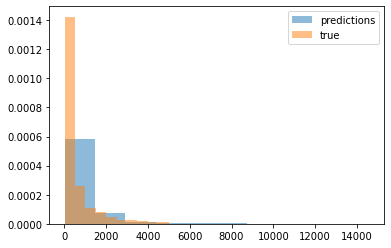

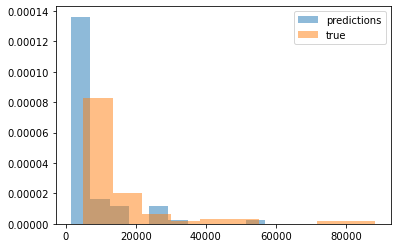

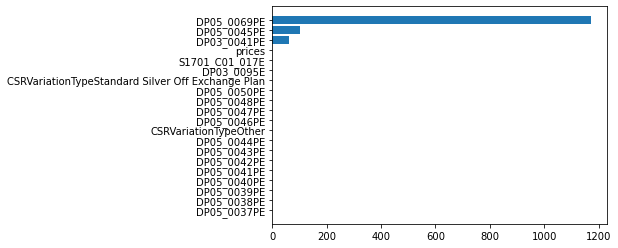

mse trial 4 :                pred  Ever Enrolled Count      pred_var    enroll_var
State                                                               
AZ     23967.978462         20137.333333     20.623107  17769.696743
TX     15597.641520         21165.857143   7943.518483  28389.619168
HI     13875.201188          6717.000000           NaN           NaN
IL     12115.009902         38193.666667  15239.904709  43650.969478
FL     12095.536716         16487.272727  15399.980520  15992.170354
MI     10189.311587          1559.000000     95.578069   1087.530229
UT      8170.321278          1213.000000           NaN           NaN
OH      7316.655897           499.500000    125.692387    226.981277
NJ      7250.960387          5044.333333   2536.597104   7269.574288
GA      6604.693745         21113.000000           NaN           NaN
TN      5849.267168         24894.000000           NaN           NaN
WI      5785.108680         28963.000000           NaN           NaN
VA      4923.517923 

In [7]:
# Vary alpha values
a = [250]

for i in a: 
    mses = []
    r2s = []
    for j in range(num_trials):
        X_train, X_test = training_test[j]
        x_cols = lasso_x_cols+logit_x_cols 
        y_cols = ['Ever Enrolled Count']
        
        #reorg data for tree
        y_train = X_train[y_cols]
        y_test = X_test[y_cols]
        X_train = X_train[x_cols]
        X_test = X_test[x_cols]
        
        #fit the model
        lasso = sm.OLS(y_train, X_train).fit_regularized(method='elastic_net', alpha=i, L1_wt=1.0)
        y_pred = get_predictions(lasso,X_test)

        mse = float(((y_test - y_pred)**2).mean())
        r2 = float( 1 - mse/y_test.var() )
        print('------------------')
        print('mse normalized trial ', j,': r2', r2)#, mse, float(true_shares.var()) )
        print('training', float(y_train.mean()) ,
          'predicted share', float(y_pred.mean()) ,'actual', float(y_test.mean()))
        print('------------------')
        mses.append(mse)
        r2s.append(r2)
        

        if j == num_trials -1:
            #plot the difference between true and predicted
            split = 5000
            plot_prediction(split,y_pred,y_test)

            #also plot important feature
            param_df = pd.DataFrame(np.abs(lasso.params),columns=['score']).sort_values(by=['score'], ascending=False).head(20)
            param_df['features'] = param_df.index
            plt.barh(param_df['features'].iloc[::-1], param_df['score'].iloc[::-1])
            plt.show()
            print('mse trial', j, ':',report_error(y_test,y_pred))

    print('alpha_value:', i)
    mses,r2s = np.array(mses),np.array(r2s)
    print( 'mse', np.array(mses).mean() ,'r2', 1 - float(np.array(mses).mean()/clean_df['Ever Enrolled Count'].var()) )
    print( 'mse med', np.median(mses) ,'r2 med',r2s.reshape(num_trials,1)[mses == np.median(mses)][0,0] )
    print('==========================================')
    print('==========================================')

In [8]:
#some training sets total number of consumers?
#some times DP03_CSR?